In [1]:
# nitanshalon, nitanshalon@wustl.edu, Shalon, Nitan
# k.sherman, k.sherman@wustl.edu, Sherman, Kenneth
# choij, jdc6@wustl.edu, Choi, Jason
# jdecavel-bueff, d.jonathan@wustl.edu, Decavel-Bueff, Jonathan

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Ridge
import random
import matplotlib.pyplot as plt
import os

In [3]:
# Perform the major preprocessing of the data, function
# depends on data task (e.g. train split, train final, test)
#
# INPUTS
# path: path to the csv reading in
# split_perc: fraction of the data goes to the test set
# label_col: column name of the value we're predicting
# id_col: id column to drop from features
# categorical: column name to one-hot encode (two nested features in the number string)
# normalize: normalize the data (T/F) -- not necessary if normalizing through scikitlearn models
# train: training data (T/F) -- does the data have labels?
# split: split data (T/F) -- are we training our final model?
#
# OUTPUTS
# x: always returned
# y: returned when training
# test_x: returned when validating models (split==T)
# test_y: returned when validating models (split==T)

def get_train_test(path, split_perc=0.25, label_col="Horizontal_Distance_To_Fire_Points", id_col="ID", 
                   categorical="Soil_Type", normalize=False, train=True, split=True):
    data = pd.read_csv(path) # read in data
    data = data.drop([id_col], axis=1) # drop the id column in the training so that it's not a feature
    climate_type_transform = onehot_encode(data[categorical], idx=0) # one-hot encode the climate feature in the data
    soil_type_transform = onehot_encode(data[categorical], idx=1) # one-hot encode the soiltype feature in the data
    if train: # only extract labels if we're on a training set
        data_labels = data[[label_col]].to_numpy() # extract labels
        drop_cols = [categorical, label_col] # columns to drop if on train set
    else:
        drop_cols = [categorical] # columns to drop if on test set
    data = data.drop(drop_cols, axis=1) # drop the categorical and labels so we can normalize the data
    
    if normalize:
        data = normalize_data(data)
        
    data = append_to_data(data, climate_type_transform, colname="climate") # return the augmented df with the one-hot encoding for soil type
    data = append_to_data(data, soil_type_transform, colname="soiltype")
    if train and split:
        return split_data(data.values, data_labels, split_perc) # if training (validating) then split the data
    elif not split:
        return data.values, data_labels # if training but getting the model to test, then don't split so we can use all the data to train
    else:
        return data.values # if testing then don't split the data and just return features

In [4]:
def normalize_data(data):
    scaler = preprocessing.MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(data.to_numpy()))

In [5]:
def onehot_encode(data, idx):
    soil_types = set() # set of unique soil types based on first two ints of the soil_type column
    for ele in data:
        soil_types.add(str(ele)[idx])
    soil_types_arr = np.array(list(soil_types))
    print("data len %s ; index %s ; number of data type %s" % (len(data), idx, len(soil_types)))
    onehots = np.zeros(shape=(len(data), len(soil_types))) # initialize the one-hot encoding for the soil type as a matrix of zeroes
    for data_ind, val in enumerate(data): # iterate through the data
        soil_type_ind = np.argwhere(soil_types_arr == str(val)[idx]) # match the data soiltype to the soil index in the feature array
        onehots[data_ind, soil_type_ind] = 1 # change the position of the corresponding soil type to a 1 for the specific data point 
    return onehots

In [6]:
# modulate the data so a column corresponds to the one-hot 
# encoding of the categorical feature passed in 
def append_to_data(data, onehots, colname):
    for typecount in range(onehots.shape[1]):
        typecount_colname = "%s=%s" % (colname, typecount)
        data[typecount_colname] = onehots[:, typecount]
    return data

In [7]:
# split the data, assining (split_perc)% of the data to the test set
def split_data(x, y, split_perc):
    n = x.shape[0]
    num_test = int(split_perc * n)
    test_inds = np.random.choice(np.arange(n), num_test)
    train_inds = np.setdiff1d(np.arange(n), test_inds)
    train_x = x[train_inds, :]
    train_y = np.reshape(y[train_inds], (len(train_inds),))
    test_x = x[test_inds, :]
    test_y = np.reshape(y[test_inds], (len(test_inds),))
    
    return train_x, train_y, test_x, test_y

In [8]:
# return RMSE
def get_loss(y_hat, y):
    return np.sqrt(np.sum(((np.array(y_hat) - np.array(y)) ** 2) / len(y)))

In [9]:
def ridge(train_x, train_y, test_x,
                alpha=1.0, get_model=False, normalize=True):
    # define model
    model = Ridge(alpha=alpha, normalize=normalize)
    model.fit(train_x, train_y)
    if get_model:
        return model
    y_hat = model.predict(test_x)
    return y_hat

In [10]:
def huber(train_x, train_y, test_x, test_y,
                   epsilon=1.35, max_iter=1e3, normalize=True):
        # define model
    model = HuberRegressor(epsilon=epsilon, max_iter=max_iter)
    model.fit(train_x, train_y)
    y_hat = model.predict(test_x)
    return y_hat

In [11]:
train_x, train_y, test_x, test_y = get_train_test("/kaggle/input/wustl-cse517a-sp21-milestone1/train.csv", split_perc=0.2)
# train_x_orig, train_y_orig, test_x_orig, test_y_orig = get_train_test("/kaggle/input/wustl-cse517a-sp21-milestone1/train.csv", normalize=False)

data len 7438 ; index 0 ; number of data type 4
data len 7438 ; index 1 ; number of data type 3


In [12]:
losses = []
reg_constants = [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0]
for alpha in reg_constants:
    losses.append(get_loss(ridge(train_x, train_y.ravel(), test_x, alpha=alpha), test_y.ravel()))

min validation loss on data: 1086, with regularization constant 5e-05


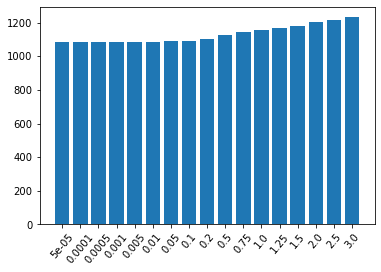

In [13]:
print("min validation loss on data: %.0f, with regularization constant %s" % (np.min(losses), reg_constants[np.argmin(losses)]))
fig = plt.figure()
plt.bar([str(r) for r in reg_constants], losses)
plt.xticks(rotation = 50)
plt.show()

In [14]:
# normilization occurs in the sklearn model, so we'll skip it on the preprocessing
# now we're training our final model to submit label predictions
train_x, train_y = get_train_test("/kaggle/input/wustl-cse517a-sp21-milestone1/train.csv", split=False)
test_x = get_train_test("/kaggle/input/wustl-cse517a-sp21-milestone1/test.csv", train=False)

data len 7438 ; index 0 ; number of data type 4
data len 7438 ; index 1 ; number of data type 3
data len 11157 ; index 0 ; number of data type 4
data len 11157 ; index 1 ; number of data type 3


In [15]:
test_model = ridge(train_x, train_y, None, get_model=True, alpha=0.00005)

In [16]:
test_preds = test_model.predict(test_x).ravel()
test_ids = pd.read_csv("/kaggle/input/wustl-cse517a-sp21-milestone1/test.csv")["ID"]
test_submission = pd.DataFrame({
    "ID" : test_ids,
    "Horizontal_Distance_To_Fire_Points" : test_preds
})

In [17]:
test_submission.to_csv('submission_v3.csv', index=False)